<a href="https://colab.research.google.com/github/bvsvarshini/-Travel-Explorer-Website/blob/main/Trader_Performance_vs_Market_Sentiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import pandas as pd
trades = pd.read_csv("historical_data.csv")
sentiment = pd.read_csv("fear_greed_index.csv")

In [4]:
trades.head()
trades.info()
trades.describe()

sentiment.head()
sentiment.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211224 entries, 0 to 211223
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Account           211224 non-null  object 
 1   Coin              211224 non-null  object 
 2   Execution Price   211224 non-null  float64
 3   Size Tokens       211224 non-null  float64
 4   Size USD          211224 non-null  float64
 5   Side              211224 non-null  object 
 6   Timestamp IST     211224 non-null  object 
 7   Start Position    211224 non-null  float64
 8   Direction         211224 non-null  object 
 9   Closed PnL        211224 non-null  float64
 10  Transaction Hash  211224 non-null  object 
 11  Order ID          211224 non-null  int64  
 12  Crossed           211224 non-null  bool   
 13  Fee               211224 non-null  float64
 14  Trade ID          211224 non-null  float64
 15  Timestamp         211224 non-null  float64
dtypes: bool(1), float64(

In [5]:
trades['Timestamp IST'] = pd.to_datetime(
    trades['Timestamp IST'],
    dayfirst=True,
    errors='coerce'
)


In [6]:
trades['Timestamp IST'].isna().sum()
trades[['Timestamp IST']].head()


,Timestamp IST
0,2024-12-02 22:50:00
1,2024-12-02 22:50:00
2,2024-12-02 22:50:00
3,2024-12-02 22:50:00
4,2024-12-02 22:50:00


In [7]:
trades['Timestamp IST'] = pd.to_datetime(
    trades['Timestamp IST'],
    dayfirst=True,
    errors='coerce'
)

trades['trade_date'] = trades['Timestamp IST'].dt.date


In [8]:
trades[['Timestamp IST', 'trade_date']].head()


,Timestamp IST,trade_date
0,2024-12-02 22:50:00,2024-12-02
1,2024-12-02 22:50:00,2024-12-02
2,2024-12-02 22:50:00,2024-12-02
3,2024-12-02 22:50:00,2024-12-02
4,2024-12-02 22:50:00,2024-12-02


In [9]:
trades['Coin'].value_counts().head(10)


,count
Coin,
HYPE,68005
@107,29992
BTC,26064
ETH,11158
SOL,10691
FARTCOIN,4650
MELANIA,4428
PURR/USDC,2774
WLD,1983


In [10]:
btc_trades = trades[trades['Coin'].str.contains('BTC', case=False)]


In [11]:
btc_trades.shape
btc_trades['Coin'].value_counts()


,count
Coin,
BTC,26064


In [12]:
btc_trades['Closed PnL'].describe()
btc_trades['Size USD'].describe()


,Size USD
count,2.606400e+04
mean,2.471732e+04
std,9.533397e+04
min,4.300000e-01
25%,5.001100e+02
50%,2.494740e+03
75%,1.988585e+04
max,3.921431e+06


In [13]:
btc_trades = btc_trades.copy()
btc_trades['is_profitable'] = btc_trades['Closed PnL'] > 0


In [14]:
btc_trades['size_bucket'] = pd.qcut(
    btc_trades['Size USD'],
    q=4,
    labels=['Small', 'Medium', 'Large', 'Whale']
)

btc_trades['pnl_ratio'] = btc_trades['Closed PnL'] / btc_trades['Size USD']


In [15]:
sentiment['date'] = pd.to_datetime(
    sentiment['date'],
    dayfirst=True,
    errors='coerce'
)

sentiment['sentiment_date'] = sentiment['date'].dt.date


In [16]:
sentiment.head()
sentiment.columns


Index(['timestamp', 'value', 'classification', 'date', 'sentiment_date'], dtype='object')

In [17]:
merged = btc_trades.merge(
    sentiment[['sentiment_date', 'classification']],
    left_on='trade_date',
    right_on='sentiment_date',
    how='left'
)


In [18]:
merged.shape
merged['classification'].value_counts()
merged['classification'].isna().mean()


np.float64(0.878683241252302)

In [19]:
sentiment = sentiment.dropna(subset=['sentiment_date'])


In [20]:
print("Sentiment date range:")
print(sentiment['sentiment_date'].min(), sentiment['sentiment_date'].max())


Sentiment date range:
2018-01-02 2025-12-04


In [21]:
valid_merged = merged[merged['classification'].notna()].copy()


In [22]:
valid_merged.shape
valid_merged['classification'].value_counts()


,count
classification,
Greed,1483
Fear,988
Extreme Greed,319
Neutral,227
Extreme Fear,145


In [23]:
valid_merged.groupby('classification')['Closed PnL'].agg(
    trades='count',
    avg_pnl='mean',
    median_pnl='median',
    win_rate=lambda x: (x > 0).mean()
)


,trades,avg_pnl,median_pnl,win_rate
classification,,,,
Extreme Fear,145,39.156426,0.0,0.275862
Extreme Greed,319,41.561424,0.0,0.319749
Fear,988,54.157691,0.0,0.318826
Greed,1483,17.311808,0.0,0.277141
Neutral,227,26.565798,0.0,0.303965


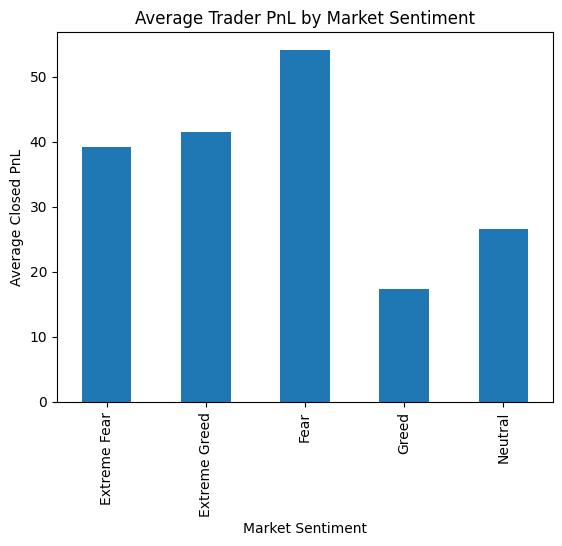

In [24]:
import matplotlib.pyplot as plt

pnl_by_sentiment = (
    valid_merged
    .groupby('classification')['Closed PnL']
    .mean()
    .sort_index()
)

plt.figure()
pnl_by_sentiment.plot(kind='bar')
plt.title("Average Trader PnL by Market Sentiment")
plt.xlabel("Market Sentiment")
plt.ylabel("Average Closed PnL")
plt.show()


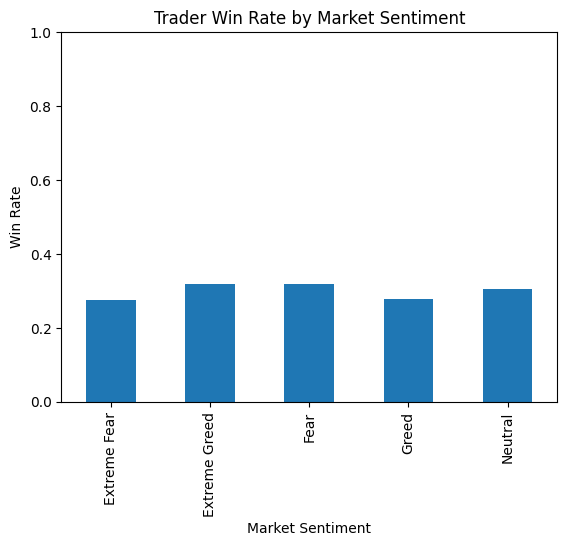

In [25]:
win_rate = (
    valid_merged
    .groupby('classification')['is_profitable']
    .mean()
)

plt.figure()
win_rate.plot(kind='bar')
plt.title("Trader Win Rate by Market Sentiment")
plt.xlabel("Market Sentiment")
plt.ylabel("Win Rate")
plt.ylim(0, 1)
plt.show()


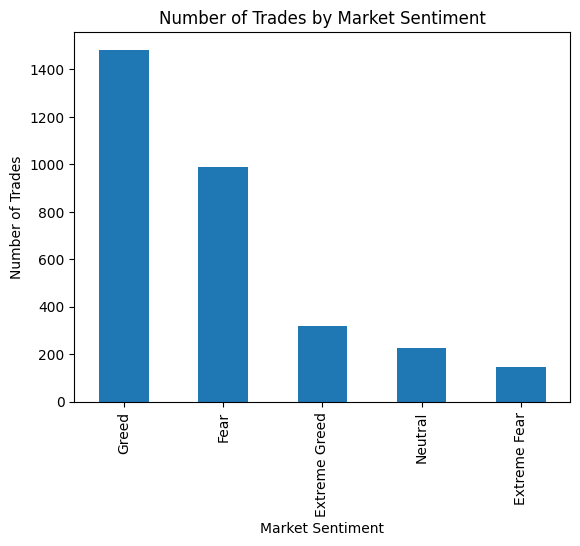

In [26]:
trade_counts = valid_merged['classification'].value_counts()

plt.figure()
trade_counts.plot(kind='bar')
plt.title("Number of Trades by Market Sentiment")
plt.xlabel("Market Sentiment")
plt.ylabel("Number of Trades")
plt.show()


<Figure size 640x480 with 0 Axes>

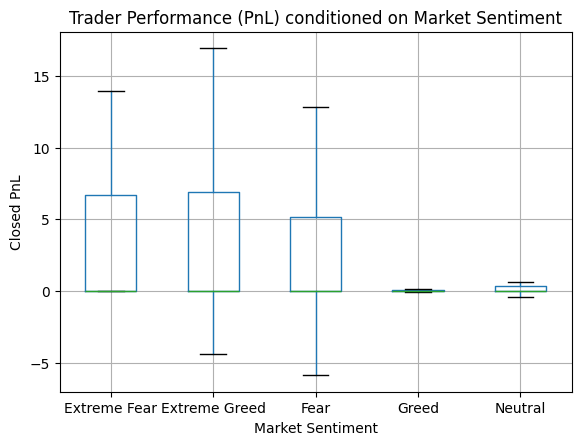

In [27]:
import matplotlib.pyplot as plt

plt.figure()
valid_merged.boxplot(
    column='Closed PnL',
    by='classification',
    showfliers=False
)
plt.title("Trader Performance (PnL) conditioned on Market Sentiment")
plt.suptitle("")
plt.xlabel("Market Sentiment")
plt.ylabel("Closed PnL")
plt.show()


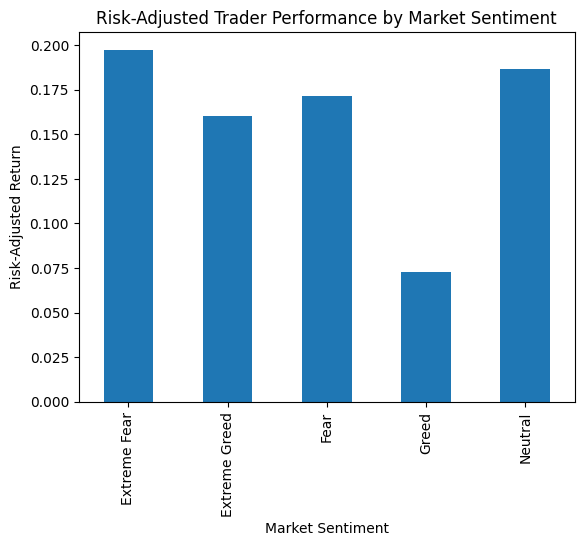

In [28]:
risk_reward = (
    valid_merged
    .groupby('classification')
    .agg(
        avg_pnl=('Closed PnL', 'mean'),
        pnl_std=('Closed PnL', 'std')
    )
)

risk_reward['risk_adjusted_return'] = (
    risk_reward['avg_pnl'] / risk_reward['pnl_std']
)

plt.figure()
risk_reward['risk_adjusted_return'].plot(kind='bar')
plt.title("Risk-Adjusted Trader Performance by Market Sentiment")
plt.xlabel("Market Sentiment")
plt.ylabel("Risk-Adjusted Return")
plt.show()


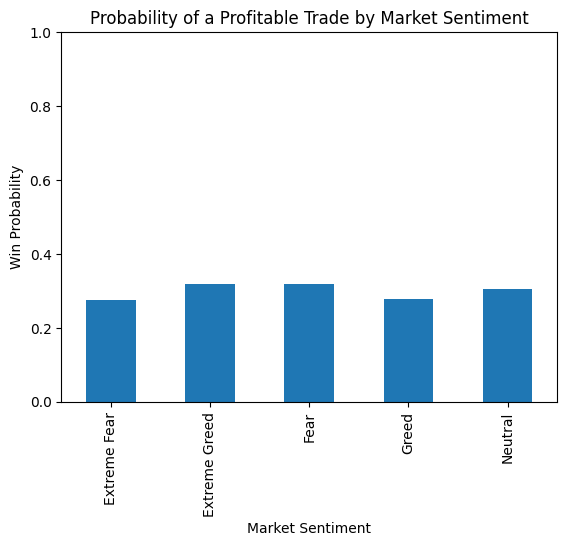

In [29]:
plt.figure()
(
    valid_merged
    .groupby('classification')['is_profitable']
    .mean()
    .plot(kind='bar')
)
plt.title("Probability of a Profitable Trade by Market Sentiment")
plt.xlabel("Market Sentiment")
plt.ylabel("Win Probability")
plt.ylim(0, 1)
plt.show()


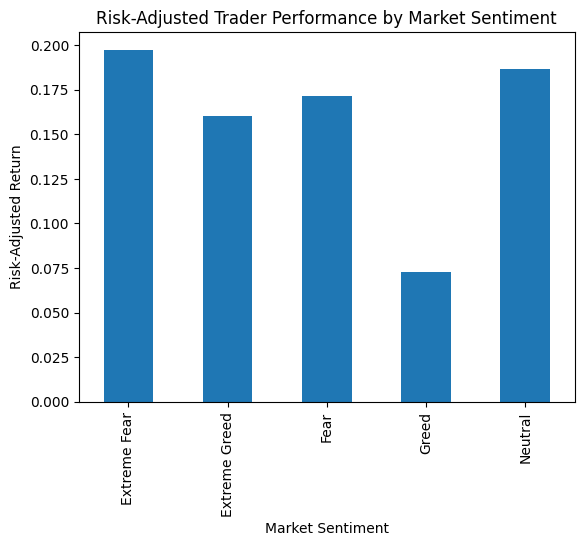

In [30]:
risk_reward = (
    valid_merged
    .groupby('classification')
    .agg(
        avg_pnl=('Closed PnL', 'mean'),
        pnl_std=('Closed PnL', 'std')
    )
)

risk_reward['risk_adjusted_return'] = (
    risk_reward['avg_pnl'] / risk_reward['pnl_std']
)

plt.figure()
risk_reward['risk_adjusted_return'].plot(kind='bar')
plt.title("Risk-Adjusted Trader Performance by Market Sentiment")
plt.xlabel("Market Sentiment")
plt.ylabel("Risk-Adjusted Return")
plt.show()


<Figure size 640x480 with 0 Axes>

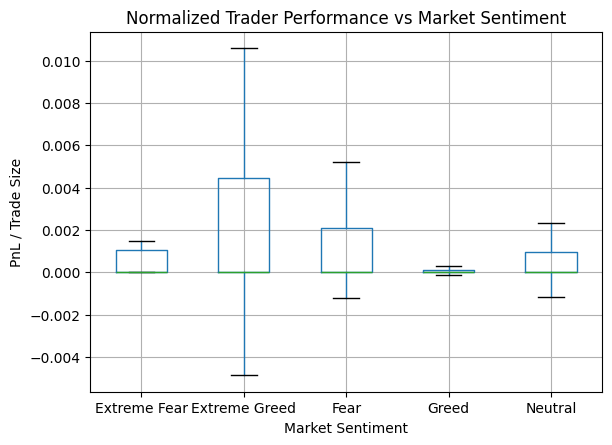

In [31]:
plt.figure()
valid_merged.boxplot(
    column='pnl_ratio',
    by='classification',
    showfliers=False
)
plt.title("Normalized Trader Performance vs Market Sentiment")
plt.suptitle("")
plt.xlabel("Market Sentiment")
plt.ylabel("PnL / Trade Size")
plt.show()
